## Machine learning for asset managers - sample code

In [297]:
### Imports
import pandas as pd
import numpy as np
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.pyplot as mpl,seaborn as sns
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
import numpy as np,scipy.stats as ss
from sklearn.metrics import mutual_info_score
import numpy as np,scipy.stats as ss
from sklearn.metrics import mutual_info_score
import datetime
import numpy as np,pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection._split import KFold
#from sklearn.metrics import log_loss
#from sklearn.model_selection._split import KFold

#import numpy as np,pandas as pd
from scipy.stats import norm,percentileofscore
#import numpy as np
from scipy.linalg import block_diag
import scipy.stats as ss

## Section 2 - Marcenko Pastur

#### Definitions

In [222]:
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    #print(pdf)
    #print(type(pdf))
    #print(np.shape(pdf))
    #print(np.shape(np.reshape(pdf, newshape = 1000)))
    #print(q)
    #print(eVal)
    #print(len(pdf))
    
    pdf=pd.Series(np.reshape(pdf,1000),index=np.reshape(eVal,len(eVal))) ## necessary to reshape array from (R,1) to (R,)
    return pdf

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

def getRndCov(nCols,nFacts):
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) # random cov matrix, however not full rank
    cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov
    return cov
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    #return pdf0
    return sse
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    #fun = errPDFs(x,eVal,q,bWidth)
    #out=minimize(fun(eVal,q,bWidth))
    out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth),bounds=((1E-5,1-1E-5),))
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var

def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
# Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts]
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:]
    corr0=np.dot(eVecL,eValL).dot(eVecL.T)
    corr1=np.dot(eVecR,eValR).dot(eVecR.T)
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1))
    return corr2

def formBlockMatrix(nBlocks,bSize,bCorr):
    block=np.ones((bSize,bSize))*bCorr
    block[range(bSize),range(bSize)]=1
    corr=block_diag(*([block]*nBlocks))
    return corr
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr)
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0=corr0[cols].loc[cols].copy(deep=True)
    std0=np.random.uniform(.05,.2,corr0.shape[0])
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

def simCovMu(mu0,cov0,nObs,shrink=False): # When shrink=True, the function performs a Ledoit–Wolf shrinkage of the empirical covariance matrix.
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1


def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w

### Working

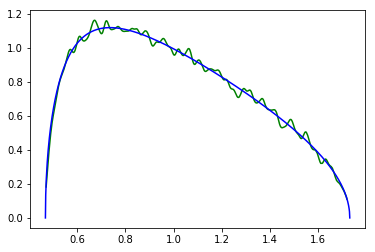

In [223]:
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
x=np.random.normal(size=(10000,1000))
eVal0,eVec0=getPCA(np.corrcoef(x,rowvar=0))
pdf0=mpPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000)
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf
plt.plot(pdf1, color = "g")
plt.plot(pdf0, color = "b")

In [ ]:
#### Why is this important? If there is a mtrix that is T*N of IID variables, and the variance is equal to one, then we 
#### can specify a matric that converges to the Marcenko Pastur pdf as T and N tend to infinity.
#### Therefore, if we have a set of IID variables, if we can denoise it or demean it s.t. the variance is equal to one, then
#### We can define a transform where we can predict the distribution og the resulting matrix values
#### in fact, this matrix will be called C and is the correlation matrix associated with X.
#### As the distribution tends to MP, so too do the eigenvalues tend to positive and negative limits. Hence, if we see eigen
#### values that are outside of these limits, then it can be said that these are associated with non-random components.
####

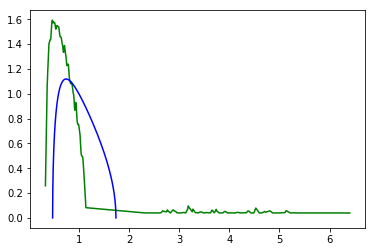

In [225]:
### This code generates a matrix where the X values are not all the result of completely random data.
alpha,nCols,nFact,q=.995,1000,100,10
cov=np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=0)
cov=alpha*cov+(1-alpha)*getRndCov(nCols,nFact) # noise+signal. Each element consists of alpha noise plus 1-alpha signal 
## where signal is a random variable vectored by itself through w*w.T. Furthermore because we multiply by the transpose,
## the signal is really only on the diagonal 
corr0=cov2corr(cov)
eVal0,eVec0=getPCA(corr0)
pdf0=mpPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000)
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf|
plt.plot(pdf1, color = "g")
plt.plot(pdf0, color = "b")


In [ ]:
### As the maximum and minimum of the eigenvalues tends towards a fixed number depending on the lambda, we can calibrate
### the lambda to find the marcenko pastur pdf that minimises the SSE between the analytical (formed from KDE) pdf and 
### the MC pdf corresponding to the chosen value of lambda

In [181]:
eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth=.01)
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
var0

0.6773059606471249

In [ ]:
### We can then plot this based on the new value of sigma.Is it alarming that the new sigma is not close to 1?
### The answer is no: because only part of the variance is caused by random eigenvectors
### Hence, the distribution the data tends to is still potentially the MP distribution, but with an amended value for sigma.
### The sigma can be calibrated based on the above, which then gives the threshold for the eigen-values
### The value of variance is about 66% which implies 33% is signal and 66% noise. This is one way of working out how much signal
### Is in each dataset.

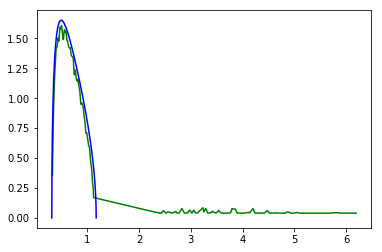

In [161]:
pdf0=mpPDF(var0,q=x.shape[0]/float(x.shape[1]),pts=1000)
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf|
plt.plot(pdf1, color = "g")
plt.plot(pdf0, color = "b")


In [35]:
### Shrinkage;
### If a covariance matrix has a large number of features but the sample is low, then the stability of the solution
### may be comrpromised. Therefore, Ledoit proposes we shrink the matrix towards the identity matrix. Under mild conditions,
### the optimal shrinkage amount tends towards a limiting constant. The resulting matrix has smaller risk and is conditioned
### better. The method below sets a constant eigen value for all random eigen vectors.

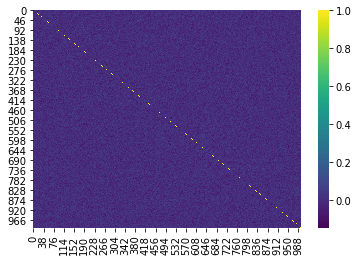

In [182]:

#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)
sns.heatmap(corr1,cmap="viridis")
eMax0_denoise,var0_denoise=findMaxEval(np.diag(eVal1),q,bWidth=.01)

In [183]:
print("the signal to noise ratio is: " + str((1-var0_denoise)/var0_denoise))

the signal to noise ratio is: 1.0000100000954499e-05


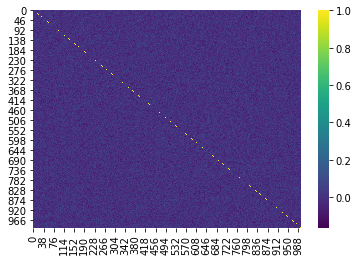

In [186]:
## instead of setting all eigenvectors that are random as a constant value, we may wish to target the shrinkage 
## This method is better in teh sense of retaining more signal but may have more noise too. Therefore it may be prudent to
## Apply both and choose the method that results in the better SNR in the denoised matrix? No. Because one necessarily has a
## higher ratio because all the noise is removed. We need to find which is better at predicting the original data.
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
corr1=denoisedCorr2(eVal0,eVec0,nFacts0,alpha=.5)
eVal1,eVec1=getPCA(corr1)
sns.heatmap(corr1,cmap="viridis")
eMax0_denoise,var0_denoise=findMaxEval(np.diag(eVal1),q,bWidth=.01)

In [187]:
print("the signal to noise ratio is: " + str((1-var0_denoise)/var0_denoise))

the signal to noise ratio is: 0.31008035350510765


In [ ]:
## DETONING
## Suppose you have a matrix of returns for a 100 different securities. These are all securities from the NYSE,
## and as such contain a market component. However, suppose we are interested in assessing the viability of
## securities for a portfolio by cluster or type. It is then prudent to remove the market component or the "tone"
## Insofar as the market component contains some level of variation, it is possible that it affects all "clusters"
## differently, therefore it is prudent to control cluster performance for the tone.
## This is equivalent to computing market-adjusted or beta-adjusted returns in regression analysis

In [ ]:
## Experimental example:
## This covariance
## matrix is a stylized representation of a true (nonempirical) detoned correlation
## matrix of the S&P 500, where each block is associated with an economic sector.
## Without loss of generality, the variances are drawn from a uniform distribution. The variances are drawn from a normal
## distrbution. This is consistent with the notion that in an efficient market all securities have the same expected Sharpe ratio.

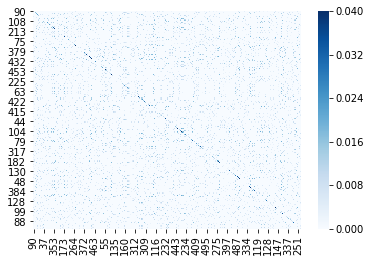

In [196]:
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)
sns.heatmap(cov0,cmap="Blues")

In [230]:

#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
nObs,nTrials,bWidth,shrink,minVarPortf=1000,1000,.01,False,True      ## Specify parameters
w1=pd.DataFrame(columns=range(cov0.shape[0]),                        ## Initiate a dataframe with 500 columns (vars) and 1k obs
index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)                                                   ## setting seed to 0 means each time rand is called array is the same
for i in range(nTrials):                                            ## iterate through for each trial
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)                  ## simCovMu generates a random set of data --> cov matrix -- . shrink if shrink is true
    if minVarPortf:                                                 ## discard the means if minvarportf is true. Should be set to false to derive maximum sharpe ratio portfolio
        mu1=None
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth)        ## de noise cov matrix
    w1.loc[i]=optPort(cov1,mu1).flatten()                       ## return the optimal portfolio; there are 1000 rows for trials and 500 columns for optimal value of each asset
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

        
### True minimum variance portfolio
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE
print(rmsd,rmsd_d)

0.004962862936087252 0.0011392025931075695


In [225]:
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE
print(rmsd,rmsd_d)

nan 0.0011392025931075695


## Section 3 - distance metrics

#### Definitions

In [243]:
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def varInfo(x,y,bins,norm=False):
    # variation of information
    cXY=np.histogram2d(x,y,bins)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=ss.entropy(np.histogram(x,bins)[0]) # marginal
    hY=ss.entropy(np.histogram(y,bins)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # normalized variation of information
    return vXY

def numBins(nObs,corr=None):
# Optimal number of bins for discretization
    if corr is None: # univariate case
        z=(8+324*nObs+12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b=round(z/6.+2./(3*z)+1./3)
    else: # bivariate case
        b=round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5)
    return int(b)
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def varInfo(x,y,norm=False):
# variation of information
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1])
    cXY=np.histogram2d(x,y,bXY)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
    hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # norma
    return vXY


def mutualInfo(x,y,norm=False):
    # mutual information
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1])
    cXY=np.histogram2d(x,y,bXY)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    if norm:
        hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
        hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
        iXY/=min(hX,hY) # normalized mutual information
    return iXY
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -


#### Working

In [234]:
### Given the limitations of correlation as an indicator (it is not a metric) , LpD suggests entropy for discrete random
### variables. Entropy cannot be used to continuous variables e.g. price, so there someone should either discretize
### the random variable (section 3.9) or use the limited density of discrete points (LLDP_)

### Calculating entropy

x = np.array([1,4,3,5,6,8,6,6,6,4])
y = np.array([3,4,0,1,4,30,1,3,4,5])
bins = 2

# Given two arrays x and y of equal size, which are discretized into a regular
# grid with a number of partitions (bins) per dimension, Code Snippet 3.1 shows
# how to compute in python the marginal entropies, joint entropy, conditional
# entropies, and the mutual information.

cXY=np.histogram2d(x,y,bins)[0]
hX=ss.entropy(np.histogram(x,bins)[0]) # marginal
hY=ss.entropy(np.histogram(y,bins)[0]) # marginal
iXY=mutual_info_score(None,None,contingency=cXY)
iXYn=iXY/min(hX,hY) # normalized mutual information
hXY=hX+hY-iXY # joint
hX_Y=hXY-hY # conditional
hY_X=hXY-hX # conditional

Both the nmi and correlation are small. This can be seen in the graph:


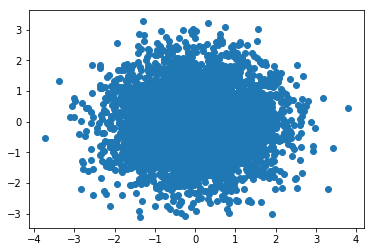

In [250]:
#####
#We begin by drawing two arrays, x and e, of random numbers from a standard
#Gaussian distribution. Then we compute y ¼ 0x þ e ¼ e, and evaluate the
#normalized mutual information as well as the correlation between x and y.
#Code Snippet 3.4 details these calculations
## i.e. there is no relationship between x and y

size,seed=5000,0
np.random.seed(seed)
x=np.random.normal(size=size)
e=np.random.normal(size=size)
y=0*x+e
nmi=mutualInfo(x,y,True)
corr=np.corrcoef(x,y)[0,1]
print("Both the nmi and correlation are small. This can be seen in the graph:")
plt.scatter(x,y)

Both the nmi and correlation are high. This can be seen in the graph:
nmi is: 0.9949768013924747
correlation is: 0.9999999949550481


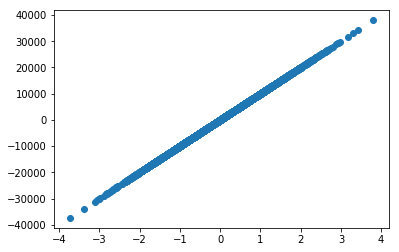

In [253]:
## Now observe with a linear relationship
size,seed=5000,0
np.random.seed(seed)
x=np.random.normal(size=size)
e=np.random.normal(size=size)
y=10**4*x+e
nmi=mutualInfo(x,y,True)
corr=np.corrcoef(x,y)[0,1]
print("Both the nmi and correlation are high. This can be seen in the graph:")
print("nmi is: " + str(nmi))
print("correlation is: " + str(corr))
plt.scatter(x,y)
## Note that when the x coefficient is lower, then the nmi is also lower.This is because the nmi is directly related to
## the correlation between x and y. So when x is relatively high, so too will be the nmi in this example

Both the nmi and correlation are high. This can be seen in the graph:
nmi is: 0.6438647001258101
correlation is: -0.00796402292795633


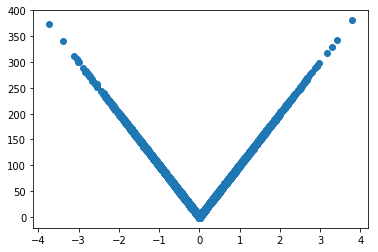

In [268]:
## Now observe with a modular relationship
modulus = lambda x: -x if x<0 else x
size,seed=5000,0
np.random.seed(seed)
x=np.random.normal(size=size)
e=np.random.normal(size=size)
y=100*np.abs(x)+e
nmi=mutualInfo(x,y,True)
corr=np.corrcoef(x,y)[0,1]
print("Both the nmi and correlation are high. This can be seen in the graph:")
print("nmi is: " + str(nmi))
print("correlation is: " + str(corr))
plt.scatter(x,y)
## Note that when the x coefficient is lower, then the nmi is also lower.This is because the nmi is directly related to
## the correlation between x and y. So when x is relatively high, so too will be the nmi in this example

In [ ]:
#Unlike in the linear case, raising the coefficient from 102 to 104 will not
#substantially increase the normalized mutual information. In this example, the
#main source of uncertainty is not e. The normalized mutual information is high,
#but not 1, because knowing y does not suffice to know x. In fact, there are two
#alternative values of x associated with each value of y.

## Conclusion: correlation is useful for measuring the degree of linear codependence between variables, but 
## an entropy-like measure should be used in conjunction if we suspect that there are non-linear codependencies
## The reason for these non-linear co-dependencies should be theory and hypothesis-motivated

## Section4 - clustering

#### Definitions

In [2]:
 def clusterKMeansBase(corr0,maxNumClusters=10,n_init=10):
     from sklearn.cluster import KMeans
     from sklearn.metrics import silhouette_samples
     dist,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series() # distance matrix
     for init in range(n_init):
            print(init)
            for i in range(2,maxNumClusters+1): # find optimal num clusters
                #print("the max clusters are: " + str (maxNumClusters+1))
                #print(str(i))
                kmeans_=KMeans(n_clusters=i,n_jobs=1,n_init=1)
                kmeans_=kmeans_.fit(dist)
                silh_=silhouette_samples(dist,kmeans_.labels_)
                stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
                if np.isnan(stat[1]) or stat[0]>stat[1]:
                    silh,kmeans=silh_,kmeans_
     n_clusters = len( np.unique( kmeans.labels_ ) )
     newIdx=np.argsort(kmeans.labels_)
     corr1=corr0.iloc[newIdx] # reorder rows
     corr1=corr1.iloc[:,newIdx] # reorder columns
     clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0] ].tolist() for i in np.unique(kmeans.labels_) } # cluster members
     silh=pd.Series(silh,index=dist.index)
     return corr1,clstrs,silh

    #------------------------------------------------------------------------------
def makeNewOutputs2(corr0,clstrs,clstrs2):
    from sklearn.metrics import silhouette_samples
    clstrsNew,newIdx={},[]
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    map(newIdx.extend, clstrsNew.values())
    corrNew=corr0.loc[newIdx,newIdx]

    dist=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs=[dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(dist,kmeans_labels),index=dist.index)
    return corrNew,clstrsNew,silhNew

def makeNewOutputs(corr0,clstrs,clstrs2):
    clstrsNew={}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    newIdx=[j for i in clstrsNew for j in clstrsNew[i]]
    corrNew=corr0.loc[newIdx,newIdx]
    x=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(x.columns))
    for i in clstrsNew.keys():
        idxs=[x.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(x,kmeans_labels),
    index=x.index)
    return corrNew,clstrsNew,silhNew
    #------------------------------------------------------------------------------
def clusterKMeansTop(corr0,maxNumClusters=10,n_init=10):
    corr1,clstrs,silh=clusterKMeansBase(corr0,maxNumClusters=min(maxNumClusters,corr0.shape[1]-1),n_init=n_init)
    clusterTstats={i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean=sum(clusterTstats.values())/float(len(clusterTstats.values()))
    redoClusters=[i for i in clusterTstats.keys() if clusterTstats[i]<tStatMean]
    if len(redoClusters)<=2:
        return corr1,clstrs,silh
    else:
        keysRedo=[];#map(keysRedo.extend,[clstrs[i] for i in redoClusters])
        for item in redoClusters:
            for j in clstrs[item]:
                keysRedo.append(j)
        corrTmp=corr0.loc[keysRedo,keysRedo]
        meanRedoTstat=np.mean([clusterTstats[i] for i in redoClusters])
        corr2,clstrs2,silh2=clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters,corrTmp.shape[1]-1),n_init=n_init)
        # Make new outputs, if necessary
        #print("The length of the  inner returned matrix is: " + str(len(corr2)))
        corrNew,clstrsNew,silhNew=makeNewOutputs(corr0, {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters},clstrs2)
        #print("The length of the  new cov matrix is: " + str(len(corrNew)))
        newTstatMean=np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean<=meanRedoTstat:
            #print("Returning old correlation matrix")
            return corr1,clstrs,silh
        else:
            #print("Returning new correlation matrix")
            return corrNew,clstrsNew,silhNew

import numpy as np,pandas as pd
from scipy.linalg import block_diag
from sklearn.utils import check_random_state
#------------------------------------------------------------------------------
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr
#------------------------------------------------------------------------------
def getCovSub(nObs,nCols,sigma,random_state=None):
    # Sub correl matrix
    rng = check_random_state(random_state)
    if nCols==1:return np.ones((1,1))
    ar0=rng.normal(size=(nObs,1))
    ar0=np.repeat(ar0,nCols,axis=1)
    ar0+=rng.normal(scale=sigma,size=ar0.shape)
    ar0=np.cov(ar0,rowvar=False)
    return ar0
#------------------------------------------------------------------------------
def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,random_state=None):
    # Generate a random correlation matrix with a given number of blocks
    rng = check_random_state(random_state)
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks),nBlocks-1,replace=False)
    parts.sort()
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks)
    parts=np.append(parts[0],np.diff( parts )) - 1 + minBlockSize
    cov=None
    for nCols_ in parts:
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)),nCols_,sigma,random_state=rng)
        if cov is None:cov=cov_.copy()
        else:cov=block_diag(cov,cov_)
    return cov
#------------------------------------------------------------------------------
def randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1):
    # Form block covar
    rng = check_random_state(random_state)
    cov0=getRndBlockCov(nCols,nBlocks,minBlockSize=minBlockSize,\
    sigma=.5,random_state=rng) # perfect block corr
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize,\
    sigma=1.,random_state=rng) # add noise
    cov0+=cov1
    corr0=cov2corr(cov0)
    corr0=pd.DataFrame(corr0)
    return corr0

#### Working

In [101]:
##
#Consider a data matrix X, of order N by F, where N is the number of objects and F is
#the number of features. We use the F features to compute the proximity between the
#N objects, as represented by an NxN matrix. The proximity measure can indicate
#either similarity (e.g., correlation, mutual information) or dissimilarity (e.g., a
#distance metric).

## Note that if the proximity matrix has a low N and large F, then there may be a curse of dimensionality that restricts the
## ability to cluster effectively. In this instance, we can reduce the dimensionality a la section 2.

#At this stage, we assume that we have a matrix that expresses our observations
#in a metric space. This matrix may have been computed as described in the
#previous section, or applying some other method. For example, the matrix may
#be based on the variation of information between random variables, as
#explained in Section 3. N

## Experimental results

##We now design a Monte Carlo experiment to verify the accuracy of the ONC
##algorithm introduced earlier: first, we create an NxN correlation matrix ρ from
##random draws with a predefined number of blocks K, where intrablock correlation is high and across-block correlation is low; second, we shuffle that correlation matrix. Third, we apply ONC, and verify that the ONC algorithm recovers
##the blocks we injected.13

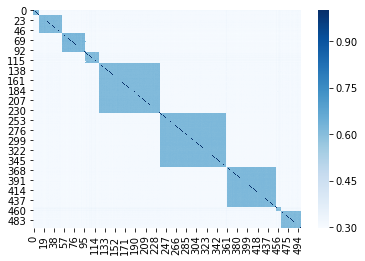

In [15]:
working_correlation = randomBlockCorr(500,10) ## generate a random correlation matrix of size 500x500 with 10 clusters

sns.heatmap(working_correlation,cmap="Blues") #sns.heatmap(working_correlation,)

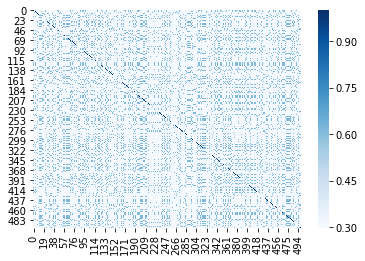

In [340]:
# Some workings below on shuffling the correlation matrix per the book
shuffled_working_correlation = working_correlation.copy(deep = True)
m = len(shuffled_working_correlation)
permutation = np.random.permutation(m)
shuffled_working_correlation = np.array(shuffled_working_correlation)
shuffled_working_correlation = shuffled_working_correlation[permutation,:]
shuffled_working_correlation = shuffled_working_correlation[:,permutation]
shuffled_working_correlation = pd.DataFrame(shuffled_working_correlation)
sns.heatmap(pd.DataFrame(shuffled_working_correlation),cmap="Blues") #sns.heatmap(working_correlation,)
### Clusters are now not recognisable but the matrix is still shuffled and has the diagonal preserved

In [96]:
## The purpose of the first step is to form a first pass estimate of E[K]. This is done using the classic k-means
## algorithm.

## [2] second step
#The purpose of this step is to perform a second-pass estimate of E[𝐾]. We evaluate the quality
#score for each cluster within the first-pass solution. Those clusters with quality greater or equal
#than average remain unchanged. We re-run the base clustering on clusters with below-average
#quality. The outputs of these re-runs are preserved only if their cluster quality improves.
## NOTE: this takes a while with 1000 obs.
[corrNew,clstrsNew,silhNew] = clusterKMeansTop(shuffled_working_correlation)

0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max cluste

In [99]:
for key,item in clstrsNew.items():
    print("Cluster: " + str(key))
    print("Members: " + str(len(item)))

Cluster: 0
Members: 124
Cluster: 1
Members: 114
Cluster: 2
Members: 92
Cluster: 3
Members: 43
Cluster: 4
Members: 44
Cluster: 5
Members: 37
Cluster: 6
Members: 11
Cluster: 7
Members: 25
Cluster: 8
Members: 10


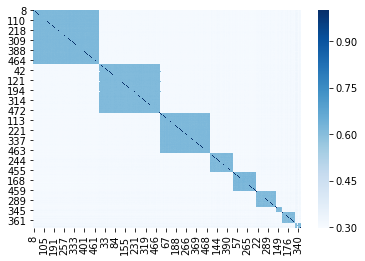

In [100]:
### The returned correlation matrix with clusters is:
sns.heatmap(corrNew,cmap = "Blues")
### If you keep repeating this process, generating the random matrix multiple times in a Monte Carlo fashion, then you
### can verify that ONC recovers the clusters effectively over time.
### One important thing to note is that if you have a set of N stocks / observations and a number F of features
### if you want to cluster similar stocks together, you will need to create a symmetric NxN matrix using the F features
### that is a "proximity" matrix, where (in the example above) correlation serves the purpose as "proximity". You
### then apply this correlation or proximity based clustering to that. 
### Similarly, if you wanted to cluster features, you could standardise and mean-tone the data and use the same methodology
### as above, where we swap N for F. Instead of using the F features to calculate proximity between say n1 and n2, you use
### all the N as observations for feature f1. You then have N observations for f1...fF. So you can calculate the covariance 
###between any two features f.



## Section 5: financial labels

#### Definitions


In [114]:
import statsmodels.api as sm1
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def tValLinR(close):
    # tValue from a linear trend
    x=np.ones((close.shape[0],2))
    x[:,1]=np.arange(close.shape[0])
    ols=sm1.OLS(close,x).fit()
    return ols.tvalues[1]
### This literally si designed to do what we did before; find the seris of time series plots where the trend is greatest.

def getBinsFromTrend(molecule,close,span):
    """
    Derive labels from the sign of t-value of linear trend
    Output includes:
    - t1: End time for the identified trend
    - tVal: t-value associated with the estimated trend coefficient
    - bin: Sign of the trend
    """
    out=pd.DataFrame(index=molecule,columns=['t1','tVal','bin'])
    hrzns=range(*span)
    for dt0 in molecule:
        df0=pd.Series()
        iloc0=close.index.get_loc(dt0)
        if iloc0+max(hrzns)>close.shape[0]:continue
        for hrzn in hrzns:
            dt1=close.index[iloc0+hrzn-1]
            df1=close.loc[dt0:dt1]
            df0.loc[dt1]=tValLinR(df1.values)
        dt1=df0.replace([-np.inf,np.inf,np.nan],0).abs().idxmax()
        out.loc[dt0,['t1','tVal','bin']]=df0.index[-1],df0[dt1],np.sign(df0[dt1]) # prevent leakage
    out['t1']=pd.to_datetime(out['t1'])
    out['bin']=pd.to_numeric(out['bin'],downcast='signed')
    return out.dropna(subset=['bin'])

def rider(molecule,close,span):
    """
    Derive labels from the sign of t-value of linear trend
    Output includes:
    - t1: End time for the identified trend
    - tVal: t-value associated with the estimated trend coefficient
    - bin: Sign of the trend
    """
    out=pd.DataFrame(index=molecule,columns=['t1','tVal','bin'])
    hrzns=range(*span)
    for dt0 in molecule:
        df0=pd.Series()
        iloc0=close.index.get_loc(dt0)
        if iloc0+max(hrzns)>close.shape[0]:continue
        for hrzn in hrzns:
            dt1=close.index[iloc0+hrzn-1]
            df1=close.loc[dt0:dt1]
            df0.loc[dt1]=tValLinR(df1.values)
        dt1=df0.replace([-np.inf,np.inf,np.nan],0).abs().idxmax()
    
        out.loc[dt0,['t1','tVal','bin']]=df0.index[-1],df0[dt1],np.sign(df0[dt1]) # prevent leakage
    out['t1']=pd.to_datetime(out['t1'])
    out['bin']=pd.to_numeric(out['bin'],downcast='signed')
    return out.dropna(subset=['bin'])

#### Working

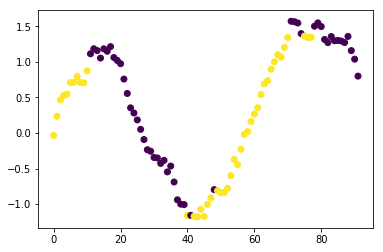

In [149]:
## Looking at time trends.
df0=pd.Series(np.random.normal(0,.1,100)).cumsum()
df0+=np.sin(np.linspace(0,10,df0.shape[0]))
df1=getBinsFromTrend(df0.index,df0,[3,10,1])
df1['t_value_times_bin'] = df1['bin'].apply(lambda x: -x if x <0 else x)
df1['t_value_times_bin'] = df1['t_value_times_bin']*df1['tVal']
mpl.scatter(df1.index,df0.loc[df1.index].values,c=df1['bin'].values, cmap='viridis')
#mpl.savefig('fig 5.1.png');mpl.clf();mpl.close()



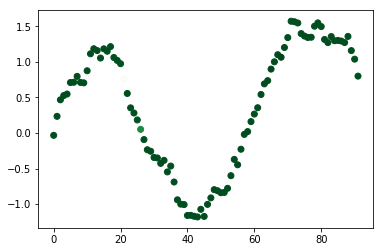

In [154]:
mpl.scatter(df1.index,df0.loc[df1.index].values,c = df1['tVal'],cmap='Greens')

### Section 6: feature importance

#### Definitions

In [210]:
def getTestData(n_features=100,n_informative=25,n_redundant=25,
    n_samples=10000,random_state=0,sigmaStd=.0):
    # generate a random dataset for a classification problem
    
    np.random.seed(random_state)
    X,y=make_classification(n_samples=n_samples,
    n_features=n_features-n_redundant,
    n_informative=n_informative,n_redundant=0,shuffle=False,
    random_state=random_state)
    cols=['I_'+str(i) for i in range(n_informative)]
    cols+=['N_'+str(i) for i in range(n_features-n_informative-n_redundant)]
    X,y=pd.DataFrame(X,columns=cols),pd.Series(y)
    i=np.random.choice(range(n_informative),size=n_redundant)
    for k,j in enumerate(i):
        X['R_'+str(k)]=X['I_'+str(j)]+np.random.normal(size=X.shape[0])*sigmaStd
    return X,y

#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDI(fit,featNames):
    # feat importance based on IS mean impurity reduction
    df0={i:tree.feature_importances_ for i,tree in \
    enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=pd.concat({'mean':df0.mean(),
    'std':df0.std()*df0.shape[0]**-.5},axis=1) # CLT
    imp/=imp['mean'].sum()
    return imp
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDA(clf,X,y,n_splits=10):
# feat importance based on OOS score reduction
    
    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0) # the fit occurs here
        prob=fit.predict_proba(X1) # prediction before shuffling
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # shuffle one column
            prob=fit.predict_proba(X1_) # prediction after shuffling
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1) # CLT
    return imp


def groupMeanStd(df0,clstrs):
    out=pd.DataFrame(columns=['mean','std'])
    for i,j in clstrs.items():
        df1=df0[j].sum(axis=1)
        out.loc['C_'+str(i),'mean']=df1.mean()
        out.loc['C_'+str(i),'std']=df1.std()*df1.shape[0]**-.5
    return out
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDI_Clustered(fit,featNames,clstrs):
    df0={i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=groupMeanStd(df0,clstrs)
    imp/=imp['mean'].sum()
    return imp


def featImpMDA_Clustered(clf,X,y,clstrs,n_splits=10):

    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=clstrs.keys())
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0)
        prob=fit.predict_proba(X1)
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
        for j in scr1.columns:
            X1_=X1.copy(deep=True)
            for k in clstrs[j]:
                np.random.shuffle(X1_[k].values) # shuffle cluster
            prob=fit.predict_proba(X1_)
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    imp.index=['C_'+str(i) for i in imp.index]
    return imp

#### Working

In [160]:
from sklearn.datasets import make_classification
import numpy as np,pandas as pd,seaborn as sns
import statsmodels.discrete.discrete_model as sm
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
ols=sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


In [177]:
### using Logit on noisy data reveals only 4 significant regressors when there is a high level of multi collinearity
out = list(ols.tvalues.apply(lambda x: -x if x < 0 else x) > 1.95 )
sig_num = 0
for i in out:
    if i== True:
        sig_num +=1

print(sig_num)
        

4


In [ ]:
## In order to address this, we can use a deision tree that utilises a threshold to create additional branches.
## THis is called mean decrease in impurity. The features and thresholds are chosen to maximise the entropy from one
## branch to the next.

In [183]:
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
max_features=1.,max_samples=1.,oob_score=False)
fit=clf.fit(X,y)
imp=featImpMDI(fit,featNames=X.columns)

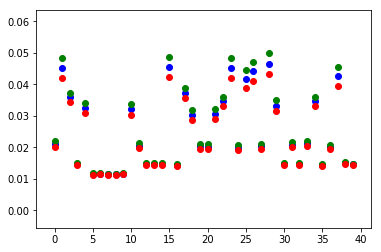

In [188]:
plt.scatter(range(len(imp)),imp['mean'],color = "blue")
plt.scatter(range(len(imp)),imp['mean'] + 2*imp['std'],color = "green")
plt.scatter(range(len(imp)),imp['mean'] - 2*imp['std'],color = "red")

In [192]:
## From the graph above, we can see the highest sets of dots correspond to the most important features.
## Limitation: How will this perform out of sample? We can apply Mean Decrease Accuracy.


In [199]:
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
max_features=1.,max_samples=1.,oob_score=False)
imp=featImpMDA(clf,X,y,10)

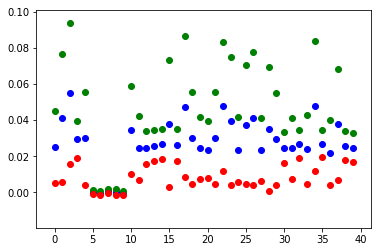

In [200]:
plt.scatter(range(len(imp)),imp['mean'],color = "blue")
plt.scatter(range(len(imp)),imp['mean'] + 2*imp['std'],color = "green")
plt.scatter(range(len(imp)),imp['mean'] - 2*imp['std'],color = "red")

In [ ]:
### However there are also problems with this approach. Broadly, given the MDA method, two features which are collinear
### can also be substituted; so the net effect will be the same but we cannot distinguish between the two.
### In order to adjudicate between collinear independent variables, we can cluster similar variables together.
#By construction, clusters are mutually dissimilar, hence taming the substitution
#effects. Because the analysis is done on a partition of the features, without a
#change of basis, results are usually intuitive.

In [205]:
## Experimental results

0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max cluste

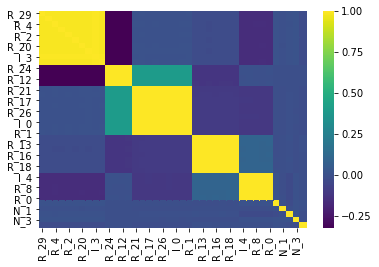

In [238]:
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
corr0,clstrs,silh=clusterKMeansBase(X.corr(),maxNumClusters=10,
n_init=10)
sns.heatmap(corr0,cmap='viridis')
#ONC correctly recognizes that there are six relevant
#clusters (one cluster for each informative feature, plus one cluster of noise features),
#and it assigns the redundant features to the cluster that contains the informative
#feature from which the redundant features were derived. Given the low correlation
#across clusters, there is no need to replace the features with their residuals

# NExt: apply clustered decision tree on data set

In [211]:
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
max_features=1.,max_samples=1.,oob_score=False)
fit=clf.fit(X,y)
imp=featImpMDI_Clustered(fit,X.columns,clstrs)

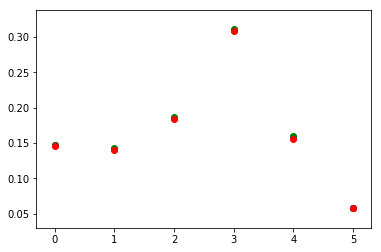

In [212]:
plt.scatter(range(len(imp)),imp['mean'],color = "blue")
plt.scatter(range(len(imp)),imp['mean'] + 2*imp['std'],color = "green")
plt.scatter(range(len(imp)),imp['mean'] - 2*imp['std'],color = "red")
## We can see from the scatter below that of the six clusters, the first 5 are presented as the most significant.
## the confidence intervals are also very tight.

In [ ]:
#This analysis has reached two correct conclusions: (1) “C_5” has
#essentially zero importance, and should be discarded as irrelevant; and (2) all
#other clusters have very similar importance. This is in contrast with what we saw
#in Figure 6.3, where some nonnoise features appeared to be much more important
#than others, even after taking into consideration the standard derivation around
#the mean values. Code Snippet 6.8 shows how these results were computed.

## Section 7 : portfolio construction

#### Definitions

In [281]:
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr)
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0=corr0[cols].loc[cols].copy(deep=True)
    std0=np.random.uniform(.05,.2,corr0.shape[0])
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1



def formBlockMatrix(nBlocks,bSize,bCorr):
    block = np.ones((bSize,bSize))* bCorr
    block[range(bSize),range(bSize)] = 1
    corr = block_diag(*([block]*nBlocks))
    return corr

def optPort_nco(cov,mu=None,maxNumClusters=10):
    cov=pd.DataFrame(cov)
    if mu is not None:mu=pd.Series(mu[:,0])
    corr1=cov2corr(cov)
    print(maxNumClusters)
    corr1,clstrs,_=clusterKMeansBase(corr1,maxNumClusters,n_init=10)
    wIntra=pd.DataFrame(0,index=cov.index,columns=clstrs.keys())
    for i in clstrs:
        cov_=cov.loc[clstrs[i],clstrs[i]].values
        if mu is None:mu_=None
        else:mu_=mu.loc[clstrs[i]].values.reshape(-1,1)
        wIntra.loc[clstrs[i],i]=optPort(cov_,mu_).flatten()
    cov_=wIntra.T.dot(np.dot(cov,wIntra)) # reduce covariance matrix
    mu_=(None if mu is None else wIntra.T.dot(mu))
    wInter=pd.Series(optPort(cov_,mu_).flatten(),index=cov_.index)
    nco=wIntra.mul(wInter,axis=1).sum(axis=1).values.reshape(-1,1)
    return nco

In [285]:
optPort_nco(cov1)

10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clu

array([[-1.99569235e-04],
       [ 1.69467819e-02],
       [-1.72524863e-03],
       [ 1.32436499e-02],
       [-7.33930942e-04],
       [ 1.71606474e-03],
       [-1.93000407e-03],
       [-2.03851780e-03],
       [-2.54489716e-03],
       [ 1.99934712e-02],
       [ 3.91711996e-04],
       [-7.46567016e-04],
       [ 2.24483873e-04],
       [-3.54012149e-03],
       [ 5.17426405e-04],
       [ 6.21972434e-03],
       [-5.52228790e-04],
       [-2.08419095e-03],
       [ 6.78718755e-03],
       [-9.90547700e-04],
       [-9.21102308e-04],
       [ 1.08565940e-03],
       [-1.79232827e-03],
       [-1.78050801e-04],
       [-2.14610714e-03],
       [-5.38740671e-04],
       [-2.37034899e-03],
       [-2.10906038e-03],
       [-1.48044497e-03],
       [ 2.97458114e-03],
       [-2.76440565e-03],
       [-1.00974053e-03],
       [ 6.15596210e-03],
       [ 9.38214182e-03],
       [-1.84015876e-03],
       [-3.46586122e-03],
       [-2.26381671e-03],
       [-2.14293915e-03],
       [-1.5

#### Working

3.0


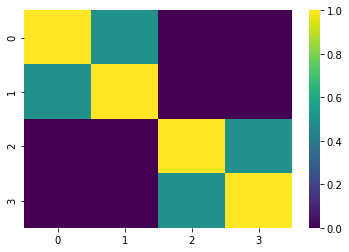

In [257]:
import matplotlib.pyplot as mpl,seaborn as sns
import numpy as np
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
corr0=formBlockMatrix(2,2,.5)
eVal,eVec=np.linalg.eigh(corr0)
print(max(eVal)/min(eVal))
sns.heatmap(corr0,cmap='viridis')

3.0


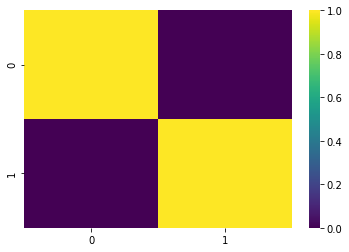

In [254]:
corr0=block_diag(formBlockMatrix(2,2,.5))
corr1=formBlockMatrix(1,2,.0)
corr0=block_diag(corr0,corr1)
eVal,eVec=np.linalg.eigh(corr0)
print(max(eVal)/min(eVal))
sns.heatmap(corr1,cmap="viridis")


0
the max clusters are: 13
2
the max clusters are: 13
3
the max clusters are: 13
4
the max clusters are: 13
5
the max clusters are: 13
6
the max clusters are: 13
7
the max clusters are: 13
8
the max clusters are: 13
9
the max clusters are: 13
10
the max clusters are: 13
11
the max clusters are: 13
12
1
the max clusters are: 13
2
the max clusters are: 13
3
the max clusters are: 13
4
the max clusters are: 13
5
the max clusters are: 13
6
the max clusters are: 13
7
the max clusters are: 13
8
the max clusters are: 13
9
the max clusters are: 13
10
the max clusters are: 13
11
the max clusters are: 13
12
2
the max clusters are: 13
2
the max clusters are: 13
3
the max clusters are: 13
4
the max clusters are: 13
5
the max clusters are: 13
6
the max clusters are: 13
7
the max clusters are: 13
8
the max clusters are: 13
9
the max clusters are: 13
10
the max clusters are: 13
11
the max clusters are: 13
12
3
the max clusters are: 13
2
the max clusters are: 13
3
the max clusters are: 13
4
the max clu

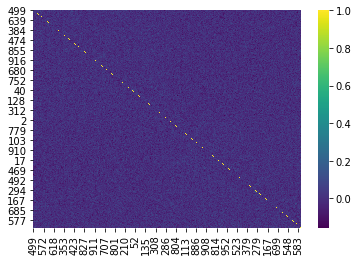

In [263]:
import pandas as pd
## Generate covariance matrix. To be honest, this should be generated with clusters but this will do for now.
alpha,nCols,nFact,q=.995,1000,100,10
cov0=np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=0)
cov0=alpha*cov+(1-alpha)*getRndCov(nCols,nFact)
cov0 = pd.DataFrame(cov0)
cols=cov0.columns
cov1=deNoiseCov(cov0,q,bWidth=.01) # de-noise cov
cov1=pd.DataFrame(cov1,index=cols,columns=cols)
corr1=cov2corr(cov1)
corr1,clstrs,silh=clusterKMeansBase(corr1,maxNumClusters=12,n_init=10)
sns.heatmap(corr1,cmap="viridis")

In [264]:
wIntra=pd.DataFrame(0,index=cov1.index,columns=clstrs.keys())
for i in clstrs:
    wIntra.loc[clstrs[i],i]=optPort(cov1.loc[clstrs[i],clstrs[i]]).flatten()
cov2=wIntra.T.dot(np.dot(cov1,wIntra)) # reduced covariance matrix

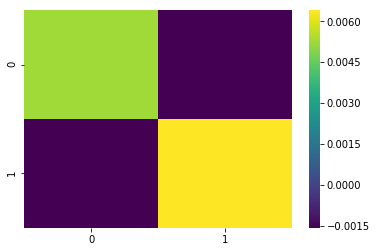

In [265]:
sns.heatmap(cov2,cmap="viridis")

In [268]:
wInter=pd.Series(optPort(cov2).flatten(),index=cov2.index)
wAll0=wIntra.mul(wInter,axis=1).sum(axis=1).sort_index()

In [272]:
# wAll0 represents the final allocations per security

### Experimental results

In [274]:
#Generate data - what we are doing here is essentially the same thing as in section 2 but by clusters.
nBlocks,bSize,bCorr =10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

In [286]:
### Monte Carlo obersvation to find the minimum variance portfolio using clustering
nObs,nSims,shrink,minVarPortf=1000,1000,False,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),                        ## Initiate a dataframe with 500 columns (vars) and 1k obs
index=range(nSims),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
#COnduct montecarlo
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    #print("commencing optPort")
    w1.loc[i]=optPort(cov1,mu1).flatten()
    #print("commencing optPort_nco")
    w1_d.loc[i]=optPort_nco(cov1,mu1).flatten()
    #w1_d.loc[i]=optPort_nco(cov1,mu1,int(cov1.shape[0]/2)).flatten()

commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters

the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11


the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPo

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max cluste

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max cluste

the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 1

the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max cluste

4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max cluste

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 1

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max cluste

the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 1

10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clu

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10


9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 1

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11


10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clu

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPo

9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11


the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters

7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10


the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters

5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max cluste

the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11


1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max cluste

the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters

4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max cluste

7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10


the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max cluste

5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max cluste

8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11


the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11


2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max cluste

5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max cluste

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max cluste

the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11


2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max cluste

the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11


the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11


the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max cluste

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11


the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11


1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max cluste

the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11


1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max cluste

4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max cluste

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11


commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max cluste

the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters

the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11


the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters

8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11


the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max cluste

the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11


2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max cluste

the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPo

the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max cluste

the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters

the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9

the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters

4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max cluste

the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10


the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters

8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max cluste

the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11


the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11


the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters

the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters

the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters

6
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
7
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
8
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPo

the max clusters are: 11
10
9
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
commencing optPort
commencing optPort_nco
10
0
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
1
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11


the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
2
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
3
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
4
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters are: 11
8
the max clusters are: 11
9
the max clusters are: 11
10
5
the max clusters are: 11
2
the max clusters are: 11
3
the max clusters are: 11
4
the max clusters are: 11
5
the max clusters are: 11
6
the max clusters are: 11
7
the max clusters

In [287]:
### Print the rootmeansq errors
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE

In [296]:
# Note - By setting minVarPortf=False, we can rerun Code Snippets 7.8 and 7.9 to derive
# the RMSE associated with the maximum Sharpe ratio portfolio. Figure 7.3
# reports the results from this experiment.

### Section 8 : backtest overfitting

#### Definitions

In [338]:

#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def getExpectedMaxSR(nTrials,meanSR,stdSR):
    # Expected max SR, controlling for SBuMT
    emc=0.577215664901532860606512090082402431042159336
    sr0=(1-emc)*norm.ppf(1-1./nTrials)+ emc*norm.ppf(1-(nTrials*np.e)**-1)
    sr0=meanSR+stdSR*sr0
    return sr0
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def getDistMaxSR(nSims,nTrials,stdSR,meanSR):
    # Monte Carlo of max{SR} on nTrials, from nSims simulations
    rng=np.random.RandomState()
    out=pd.DataFrame()
    nSims = int(nSims)
    for nTrials_ in nTrials:
        #1) Simulated Sharpe ratios
        sr=pd.DataFrame(rng.randn(nSims,nTrials_))
        sr=sr.sub(sr.mean(axis=1),axis=0) # center
        sr=sr.div(sr.std(axis=1),axis=0) # scale
        sr=meanSR+sr*stdSR
        #2) Store output
        out_=sr.max(axis=1).to_frame('max{SR}')
        out_['nTrials']=nTrials_
        out=out.append(out_,ignore_index=True)
    return out

def getMeanStdError(nSims0,nSims1,nTrials,stdSR=1,meanSR=0):
# Compute standard deviation of errors per nTrial
# nTrials: [number of SR used to derive max{SR}]
# nSims0: number of max{SR} used to estimate E[max{SR}]
# nSims1: number of errors on which std is computed
    sr0=pd.Series({i:getExpectedMaxSR(i,meanSR,stdSR) for i in nTrials})
    sr0=sr0.to_frame('E[max{SR}]')
    sr0.index.name='nTrials'
    err=pd.DataFrame()
    for i in range(int(nSims1)):
        sr1=getDistMaxSR(nSims=1E3,nTrials=nTrials,meanSR=0,stdSR=1)
        sr1=sr1.groupby('nTrials').mean()
        err_=sr0.join(sr1).reset_index()
        err_['err']=err_['max{SR}']/err_['E[max{SR}]']-1.
        err=err.append(err_)
    out={'meanErr':err.groupby('nTrials')['err'].mean()}
    out['stdErr']=err.groupby('nTrials')['err'].std()
    out=pd.DataFrame.from_dict(out,orient='columns')
    return out


#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def getZStat(sr,t,sr_=0,skew=0,kurt=3):
    z=(sr-sr_)*(t-1)**.5
    z/=(1-skew*sr+(kurt-1)/4.*sr**2)**.5
    return z
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def type1Err(z,k=1):
    # false positive rate
    alpha=ss.norm.cdf(-z)
    alpha_k=1-(1-alpha)**k # multi-testing correction
    return alpha_k
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def main0():
    # Numerical example
    t,skew,kurt,k,freq=1250,-3,10,10,250
    sr=1.25/freq**.5;sr_=1./freq**.5
    z=getZStat(sr,t,0,skew,kurt)
    alpha_k=type1Err(z,k=k)
    print(alpha_k)
    return

#### Working

In [ ]:
## The premise of this section is that due to the way researchers select strategies, there is a high probability
## that the successful strategies constitute false positives
## Broadly, suppose you have N strategies which are each tested S times. Of the S*N trials, you eseentially
## pick the strategy N that has the highest Sharpe Ratio from the S. Hence, we are sampling a maximum sharp ratio
## From a distribution. de Prado's point is that under such assumptions / environments, we need to add a test
## that essentially gives a probability of having just detected a false positive.



In [332]:
if __name__=='__main__':
    nTrials=list(set(np.logspace(1,6,100).astype('int')));nTrials.sort()
    print(type(nTrials[0]))
    sr0=pd.Series({i:getExpectedMaxSR(i,meanSR=0,stdSR=1) for i in nTrials})
    sr1=getDistMaxSR(nSims=1E2,nTrials=nTrials,meanSR=0,stdSR=1)

<class 'numpy.int32'>


In [339]:
if __name__=='__main__':
    nTrials=list(set(np.logspace(1,6,100).astype(int)));nTrials.sort()
    stats=getMeanStdError(nSims0=1E2,nSims1=1E2,nTrials=nTrials,stdSR=1)

KeyboardInterrupt: 

In [336]:
### Type 1 error
"""
Let us illustrate the above calculations with a numerical example.
Suppose that after conducting 1,000 trials, we identify an investment
strategy with a Sharpe ratio of 0.0791 (nonannualized), skewness of
−3, kurtosis of 10, computed on 1,250 daily observations (five years, at
250 annual observations). These levels of skewness and kurtosis are
typical of hedge fund returns sampled with daily frequency. From these
inputs we derive ^z½0 ≈ 2:4978 and α ≈ 0:0062. At this type I error probability,
most researchers would reject the null hypothesis, and declare that a new
investment strategy has been found. However, this α is not adjusted for the
E½K trials it took to find this strategy. We apply our ONC algorithm, and
conclude that out of the 1,000 (correlated) trials, there are E½K ¼ 10 effectively
independent trials (again, with “effectively” independent we do not assert that
the ten clusters are strictly independent, but that the algorithm could not find
more uncorrelated groupings). Then, the corrected FWER is αK ≈ 0:0608. Even
though the annualized Sharpe ratio is approx. 1.25, the probability that this
strategy is a false discovery is relatively high, for two reasons: (1) the number of
trials, since αK ¼ α ≈ 0:0062 if E½K ¼ 1; (2) the non-Normality of the returns,
since αK ≈ 0:0261 should returns have been Normal. As expected, wrongly
assuming Normal returns leads to a gross underestimation of the type I error
probability"""

'\nLet us illustrate the above calculations with a numerical example.\nSuppose that after conducting 1,000 trials, we identify an investment\nstrategy with a Sharpe ratio of 0.0791 (nonannualized), skewness of\n−3, kurtosis of 10, computed on 1,250 daily observations (five years, at\n250 annual observations). These levels of skewness and kurtosis are\ntypical of hedge fund returns sampled with daily frequency. From these\ninputs we derive ^z½0 ≈ 2:4978 and α ≈ 0:0062. At this type I error probability,\nmost researchers would reject the null hypothesis, and declare that a new\ninvestment strategy has been found. However, this α is not adjusted for the\nE½K trials it took to find this strategy. We apply our ONC algorithm, and\nconclude that out of the 1,000 (correlated) trials, there are E½K ¼ 10 effectively\nindependent trials (again, with “effectively” independent we do not assert that\nthe ten clusters are strictly independent, but that the algorithm could not find\nmore uncorrelated 

In [334]:
import scipy.stats as ss
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def getZStat(sr,t,sr_=0,skew=0,kurt=3):
    z=(sr-sr_)*(t-1)**.5
    z/=(1-skew*sr+(kurt-1)/4.*sr**2)**.5
    return z
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def type1Err(z,k=1):
# false positive rate
    alpha=ss.norm.cdf(-z)
    alpha_k=1-(1-alpha)**k # multi-testing correction
    return alpha_k
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def main0():
    # Numerical example
    t,skew,kurt,k,freq=1250,-3,10,10,250
    sr=1.25/freq**.5;sr_=1./freq**.5
    z=getZStat(sr,t,0,skew,kurt)
    alpha_k=type1Err(z,k=k)
    print(alpha_k)
    return
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
if __name__=='__main__':main0()

0.060760769078662125


In [ ]:
### Type 2 error; per above
"""
Let us apply the above equations to the numerical example in the previous
section. There, we estimated that the FWER was αK ≈ 0:0608, which implies a
critical value zα ≈ 2:4978. Then, the probability of missing a strategy with a true
Sharpe ratio SR ≈ 0:0632 (nonannualized) is β ≈ 0:6913, where θ ≈ 1:9982.
This high individual Type II error probability is understandable, because the
test is not powerful enough to detect such a weak signal (an annualized Sharpe
ratio of only 1.0) after a single trial. But because we have conducted ten trials,
βK ≈ 0:0249. The test detects more than 97.5% of the strategies with a true
Sharpe ratio SR ≥ 0:0632. Code Snippet 8.4 provides the python code that
replicates these results (see Code Snippet 8.3 for functions getZStat and
type1Err)."""
def getTheta(sr,t,sr_=0,skew=0,kurt=3):
    theta=sr_*(t-1)**.5
    theta/=(1-skew*sr+(kurt-1)/4.*sr**2)**.5
    return theta
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def type2Err(alpha_k,k,theta):
    # false negative rate
    z=ss.norm.ppf((1-alpha_k)**(1./k)) # Sidak’s correction
    beta=ss.norm.cdf(z-theta)
    return beta
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def main0():
    # Numerical example
    t,skew,kurt,k,freq=1250,-3,10,10,250
    sr=1.25/freq**.5;sr_=1./freq**.5
    z=getZStat(sr,t,0,skew,kurt)
    alpha_k=type1Err(z,k=k)
    theta=getTheta(sr,t,sr_,skew,kurt)
    beta=type2Err(alpha_k,k,theta)
    beta_k=beta**k
    print("beta_k is: " + str(beta_k))
    return
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
if __name__=='__main__':main0()